 ## References 

 *note that this is binary classification*
 
 MLP with pytorch at end
 
 * Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
 * Sample/starter code: https://github.com/Nir-J/ML-Projects/blob/master/UNSW-Network_Packet_Classification/unsw.py

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

# Preprocessing (transformation/scaling) 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


In [4]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'DoS', 'Analysis', 'Exploits', 'Worms', 'Reconnaissance', 'Normal', 'Fuzzers', 'Generic', 'Shellcode', 'Backdoor'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, ['Normal']
mode 0.3609225646458884 %


In [5]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(3)

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,0


In [6]:
## OMITTED: For statistical feature removal

lowSTD = list(combined_data.std().to_frame().nsmallest(6, columns=0).index)
# this is stupid. suppose a feature has a 1.0 (spearman or pearson) correlation, OR conditional probability, when not 0.... That a very useful feature  

lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
# This might be stupid. A Deep MLP (feed forward neural net) may see patterns

drop = set( lowCORR + lowSTD)
drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
# print(f'Before {combined_data.shape}')
combined_data_reduced=combined_data # .drop(drop,axis=1)
# print(f'After {combined_data.shape}')

In [7]:
# # transform = list(combined_data_reduced.columns.values[4:])
# transform.append('dur')
# transform.remove('attack_cat')
# # transform min-max norm 
# combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [11]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42) # TODO

In [12]:
#combined_data_reduced.where(combined_data_reduced['label'] == 1.0).dropna().tail(20)

In [13]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(206138, 42)

(206138, 1)

(51535, 42)

(51535, 1)

# Benchmark before feature removal

In [15]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500, n_jobs=-1) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.95240 for the RandomForestClassifier
Acc: 0.95133 for the ExtraTreesClassifier
Acc: 0.93653 for the XGBClassifier
Acc: 0.95269 for the LGBMClassifier


In [16]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
plt.show()

Acc: 0.95353 for the EnsembleVoteClassifier


In [22]:
# !pip install catboost
import catboost

CBC = catboost.CatBoostClassifier(iterations=3000, eval_metric='AUC', use_best_model=True, task_type="GPU", devices='0:1', random_seed=42, verbose=False)
_ = CBC.fit(X_train,y_train, eval_set=(X_test, y_test))
pred = CBC.score(X_test,y_test)
name = str(type(CBC)).split(".")[-1][:-2]
print("Acc: %0.5f for the %s" % (pred, name))
list_of_CLFs.append(CBC)

Acc: 0.95246 for the CatBoostClassifier


In [23]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.95362 for the EnsembleVoteClassifier


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC
n = 10 

### Try RFE

In [ ]:
rfe = RFE(DecisionTreeClassifier(), n).fit(X_train, y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

print('new shape', X_train_RFE.shape) 

for clf in list_of_CLFs:
    _ = clf.fit(X_train_RFE,y_train)
    pred = clf.score(X_test_RFE,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train_RFE, y_train)
pred = eclf.score(X_test_RFE, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_RFE)
probas = eclf.predict_proba(X_test_RFE)
plt.show()

new shape (128836, 10)
Acc: 0.93105 for the DecisionTreeClassifier
Acc: 0.94435 for the RandomForestClassifier
Acc: 0.94256 for the ExtraTreesClassifier
Acc: 0.93153 for the XGBClassifier
Acc: 0.94404 for the LGBMClassifier
Acc: 0.94357 for the EnsembleVoteClassifier


### Try SVD

In [ ]:
svd = TruncatedSVD(n_components=n).fit(X_train)
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

for clf in list_of_CLFs:
    _ = clf.fit(X_train_svd, y_train)
    pred = clf.score(X_test_svd, y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train_svd, y_train)
pred = eclf.score(X_test_svd, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_svd)
probas = eclf.predict_proba(X_test_svd)
plt.show()

Acc: 0.87012 for the DecisionTreeClassifier
Acc: 0.89119 for the RandomForestClassifier
Acc: 0.88867 for the ExtraTreesClassifier
Acc: 0.87150 for the XGBClassifier
Acc: 0.88599 for the LGBMClassifier
Acc: 0.88839 for the EnsembleVoteClassifier


# Benchmark after additional feature removal

 **predicting *label*:** 
```
RFE only 
Acc: 0.9259010116 [DecisionTreeClassifier]
Acc: 0.9258389175 [RandomForestClassifier]
Acc: 0.9255957155 [ExtraTreesClassifier]
Acc: 0.9259010116 [Ensemble]
number of features 20
---------------
Acc: 0.9386820522
number of features 10
[ pipeing to SVD 9 dimentions yeilds:  Acc: 0.9221753642 [Ensemble] ; piping to PCA will yeild .921] 
```
```
(64418, 20)
* Acc: 0.9283589040 [DecisionTreeClassifier]
* Acc: 0.9278052314 [RandomForestClassifier]
* Acc: 0.9286848982 [ExtraTreesClassifier]
* Acc: 0.9278000569 [Ensemble]
```
```
(64418, 10)
Acc: 0.9141341751 [DecisionTreeClassifier]
Acc: 0.9145119143 [RandomForestClassifier]
Acc: 0.9141290005 [ExtraTreesClassifier]
Acc: 0.9135028848 [Ensemble]
```




# Lets' try another way

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import RidgeClassifier
# from sklearn.svm import SVC
# seed = 1075
# np.random.seed(seed)
# # Create classifiers
# rf = RandomForestClassifier()
# et = ExtraTreesClassifier()
# knn = KNeighborsClassifier()
# svc = SVC()
# rg = RidgeClassifier()

In [ ]:
# clf_array = [rf, et, knn, svc, rg]
# for clf in clf_array:
#     vanilla_scores = cross_val_score(clf, X_train_RFE, y_train, cv=3, n_jobs=-1)
#     bagging_clf = BaggingClassifier(clf, 
#        max_samples=0.4, max_features=10, random_state=seed)
#     bagging_scores = cross_val_score(bagging_clf, X_test, y_test, cv=3, 
#        n_jobs=-1)
    
#     print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
#     print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

# Onto Deep Learning 
> I ran SVD/PCA to reduce variance since my goal to "get the best deep learning results possible" 

^ I wrote that 18 months. not sure why that really "matters". now I prefer to given `full` data to my ANNs, and let them `learn` to ignore useless features

#### Now that I try this, I get worse results, I must have done somthing breaking. This is not my goal, `UNSW-NB15_Unsupervised` is. So, ill leave this broken.  

```
Notes: 

sigmoid for binary 

Softmax = non-binary 

```


In [ ]:
X = X_train#_RFE
X_t = X_test#_RFE


dim = X.shape[1]
dim

42

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# mms = MinMaxScaler()
# X_train_svd = mms.fit_transform(X_train_svd)
# X_test_svd = mms.transform(X_test_svd)

In [ ]:
# classifier = Sequential()
# #First Hidden Layer
# classifier.add(Dense(42, activation='relu', input_dim=dim))

# classifier.add(Dense(64, activation='relu'))
# classifier.add(Dropout(0.07))
# classifier.add(Dense(42, activation='relu' ))
# classifier.add(Dropout(0.07))
# classifier.add(Dense(25, activation='relu'))

# classifier.add(Dense(1, activation='sigmoid'))

# classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
# history = classifier.fit(X,y_train, batch_size=64, epochs=5, validation_data=(X_t,y_test)).history

Epoch 1/5
2014/2014 [==============================] - 8s 4ms/step - loss: 50.5042 - accuracy: 0.6566 - val_loss: 0.6369 - val_accuracy: 0.6582
Epoch 2/5
2014/2014 [==============================] - 8s 4ms/step - loss: 0.6497 - accuracy: 0.6567 - val_loss: 0.6374 - val_accuracy: 0.6583
Epoch 3/5
2014/2014 [==============================] - 8s 4ms/step - loss: 3.7684 - accuracy: 0.6567 - val_loss: 0.6356 - val_accuracy: 0.6581
Epoch 4/5
2014/2014 [==============================] - 8s 4ms/step - loss: 2.6688 - accuracy: 0.6565 - val_loss: 0.6326 - val_accuracy: 0.6582
Epoch 5/5
2014/2014 [==============================] - 8s 4ms/step - loss: 0.6481 - accuracy: 0.6567 - val_loss: 0.6323 - val_accuracy: 0.6580


In [ ]:
# eval_model=classifier.evaluate(X, y_train)
# print(eval_model)

# eval_model=classifier.evaluate(X_t, y_test)
# print(eval_model)


# predictions=classifier.predict(X_t)
# predictions =(predictions>0.80)

# mse = np.mean(np.power(X_t - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
# error_df.describe()

4027/4027 [==============================] - 7s 2ms/step - loss: 0.6277 - accuracy: 0.6576
[0.627747654914856, 0.6575723886489868]
4027/4027 [==============================] - 7s 2ms/step - loss: 0.6323 - accuracy: 0.6580
[0.632307231426239, 0.6580407619476318]


,reconstruction_error,true_class
count,1.288370e+05,128837.000000
mean,1.376142e+17,0.639583
std,1.949670e+17,0.480123
min,1.025000e+02,0.000000
25%,1.075202e+14,0.000000
50%,3.809530e+15,1.000000
75%,2.531557e+17,1.000000
max,8.779157e+17,1.000000


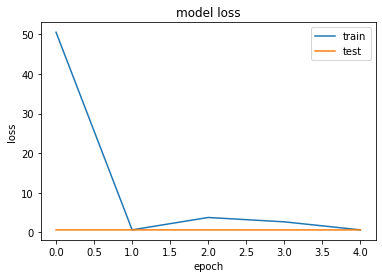

In [ ]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right');

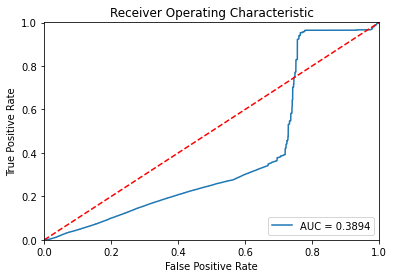

In [ ]:
# fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
# roc_auc = auc(fpr, tpr)


# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.001, 1])
# plt.ylim([0, 1.001])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

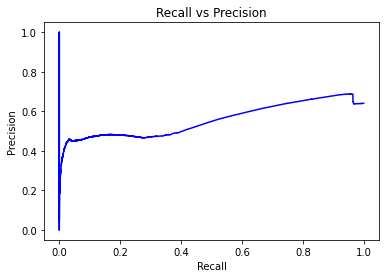

In [ ]:
# precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
# plt.plot(recall, precision, 'b', label='Precision-Recall curve')
# plt.title('Recall vs Precision')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.show()

In [ ]:
## MLP with Pytorch 

This code has only been run on `UNSW_NB15 - Torch MLP and autoEncoder`

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

input_size = 10
hidden_size = 64 
hidden_size_2 = 64
num_classes = 10

num_epochs = 40
batch_size = 32
learning_rate = 0.001

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size # ?? 
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size_2)  
        self.l3 = nn.Linear(hidden_size_2, num_classes)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(X_train)

X_train_RFE_vals= X_train_RFE.values
y_train_vals = y_train.values

for epoch in range(num_epochs):
    # for i in range(len(X_train_RFE_vals)//100 + 1): #, batch_size
    for i in range(0, X_train_RFE_vals.shape[0], batch_size):


        x = torch.as_tensor(X_train_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_train_vals[i:i+batch_size], dtype=torch.long).to(device)

        # x.type()
        # y.type()
        
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
X_test_RFE_vals= X_test_RFE.values
y_test_vals = y_test.values
with torch.no_grad():
    n_correct = 0
    n_samples = 0 
    # for i in range(len(X_train_RFE_vals)//100 + 1):   
    for i in range(0, X_test_RFE_vals.shape[0], batch_size):
        x = torch.as_tensor(X_test_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_test_vals[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(x)
        if len(outputs.data) > 0:
          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, dim=1)
          n_samples += y.size(0)
          n_correct += (predicted == y).sum().item()
        else:
          print("what???")
          print(x, outputs.data)
    acc = 100.0 * n_correct / (n_samples+1)
    print(f'Accuracy of the network: {acc} %')

In [ ]:
> Accuracy of the network: 79.64342818112668 %